**Problem Statement**

- Salary prediction of nurses
- part-time/non-regular jobs are out of scope, target nurses are
    - `REGISTERED NURSE`,
    - `LICENSED VOCATIONAL NURSE`
    - `NURSING ASSISTANT`
    - `NURSE MANAGER`
    - `PUBLIC HEALTH NURSE`
- only nurses who work more than 5 years

# Import

In [1]:
import pandas as pd
import numpy as np

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Load raw data

- including not only nurses but also other jobs 
- uppercase all names and job titles 

In [2]:
rawdata = pd.read_csv('./data/san-francisco-payroll_2011-2019.csv',low_memory=False)
rawdata['Employee Name']=rawdata['Employee Name'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z0-9 ]', '', regex=True)
rawdata['Job Title']=rawdata['Job Title'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z ]', '', regex=True)
rawdata

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,JANET LEE MILLER,COURT STAFF ATTORNEY II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
3,KRISTIAN C SMOCK,STATIONARY ENG SEWAGE PLANT,106816.03,0.0,0.0,38729.65,106816.03,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,94039.13,14947.99,1241.69,35330.26,110228.81,145559.07,2019,FT
...,...,...,...,...,...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,46106.73,890.49,4839.07,Not Provided,51836.29,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,48472.4,1972.35,1390.5,Not Provided,51835.25,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,46046.29,1853.97,3934.44,Not Provided,51834.70,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,47798.87,0.0,4032.55,Not Provided,51831.42,51831.42,2011,NaN


# Preprocessing

## filter only target nurses

In [3]:
NURSES = ['REGISTERED NURSE',
'LICENSED VOCATIONAL NURSE',
'NURSING ASSISTANT',
'NURSE MANAGER',
'PUBLIC HEALTH NURSE']

data = rawdata[rawdata['Job Title'].isin(NURSES)].reset_index(drop=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,49883.47,0.0,484.88,Not Provided,50368.35,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,48489.15,0.0,1862.64,Not Provided,50351.79,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,44727.19,567.18,4647.31,Not Provided,49941.68,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,43183.6,5962.24,3660.48,Not Provided,52806.32,52806.32,2011,NaN


## check duplicated employee name
- group by (employee name, year) -> must be 1

In [4]:
grouped = data.groupby(['Employee Name', 'Year']).count()['Job Title']
grouped

Employee Name        Year
AACE WU              2018    1
                     2019    1
AARON CRAMER         2011    1
                     2012    1
AARON LY             2015    1
                            ..
ZOSIMA P PANGILINAN  2017    1
                     2018    1
                     2019    1
ZOSIMA PANGILINAN    2011    1
                     2012    1
Name: Job Title, Length: 16497, dtype: int64

In [5]:
grouped[grouped > 1]

Employee Name        Year
MARGARITA HERRERA    2012    2
MARGARITA L HERRERA  2017    2
MARIA CRUZ           2012    2
NANCY KRAUSS         2012    2
XING C CUI           2017    2
Name: Job Title, dtype: int64

- `MARGARITA HERRERA` and `MARGARITA L HERRERA` may be identical

In [6]:
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


In [7]:
data[data['Employee Name'] == 'MARGARITA L HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN


In [8]:
## rename `MARGARITA L HERRERA`
data['Employee Name'] = data['Employee Name'].replace('MARGARITA L HERRERA', 'MARGARITA HERRERA')

In [9]:
## replaced
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


## filter only those who have 2019 salary

In [10]:
employees = data.groupby('Employee Name')['Year'].max() # latest year
employees = employees[employees == 2019] # only latest year == 2019
employees

Employee Name
AACE WU                2019
AARON LY               2019
AARON R RAINEY         2019
AARON S CRAMER         2019
ABIGAIL I ESPINO       2019
                       ... 
ZENAIDA L RAMOS        2019
ZERINA O BANGAWAN      2019
ZEXU FANG              2019
ZIYING TAN             2019
ZOSIMA P PANGILINAN    2019
Name: Year, Length: 2032, dtype: int64

In [11]:
data = data[data['Employee Name'].isin(employees.index)]
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16421,TATYANA VOVCHOK,LICENSED VOCATIONAL NURSE,64795.23,0.0,200.0,Not Provided,64995.23,64995.23,2011,NaN
16430,MEGAN BRIZZOLARA,REGISTERED NURSE,53616.02,3743.9,6708.44,Not Provided,64068.36,64068.36,2011,NaN
16431,TATYANA LITVINOVA,REGISTERED NURSE,57450.0,775.57,5830.46,Not Provided,64056.03,64056.03,2011,NaN
16470,DENISE GOMEZ PADILLA,REGISTERED NURSE,39236.1,0.0,5337.41,Not Provided,44573.51,44573.51,2011,NaN


## filter only those who have same job title
- i.e. exclude those who change job title

In [12]:
employees = data.groupby('Employee Name')['Job Title'].nunique()
employees = employees[employees == 1]
employees

Employee Name
AACE WU                1
AARON LY               1
AARON R RAINEY         1
AARON S CRAMER         1
ABIGAIL I ESPINO       1
                      ..
ZENAIDA L RAMOS        1
ZERINA O BANGAWAN      1
ZEXU FANG              1
ZIYING TAN             1
ZOSIMA P PANGILINAN    1
Name: Job Title, Length: 1963, dtype: int64

In [13]:
data = data[data['Employee Name'].isin(employees.index)]
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16421,TATYANA VOVCHOK,LICENSED VOCATIONAL NURSE,64795.23,0.0,200.0,Not Provided,64995.23,64995.23,2011,NaN
16430,MEGAN BRIZZOLARA,REGISTERED NURSE,53616.02,3743.9,6708.44,Not Provided,64068.36,64068.36,2011,NaN
16431,TATYANA LITVINOVA,REGISTERED NURSE,57450.0,775.57,5830.46,Not Provided,64056.03,64056.03,2011,NaN
16470,DENISE GOMEZ PADILLA,REGISTERED NURSE,39236.1,0.0,5337.41,Not Provided,44573.51,44573.51,2011,NaN


## check datatype

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10255 entries, 0 to 16491
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee Name         10255 non-null  object 
 1   Job Title             10255 non-null  object 
 2   Base Pay              10255 non-null  object 
 3   Overtime Pay          10255 non-null  object 
 4   Other Pay             10255 non-null  object 
 5   Benefits              10255 non-null  object 
 6   Total Pay             10255 non-null  float64
 7   Total Pay & Benefits  10255 non-null  float64
 8   Year                  10255 non-null  int64  
 9   Status                7516 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 881.3+ KB


- why is `Base Play` string? 
- include `"Not Provided"`

In [15]:
## replace with 0 -> drop after
data = data.replace('Not Provided', 0)
data['Base Pay'] = data['Base Pay'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10255 entries, 0 to 16491
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee Name         10255 non-null  object 
 1   Job Title             10255 non-null  object 
 2   Base Pay              10255 non-null  float64
 3   Overtime Pay          10255 non-null  object 
 4   Other Pay             10255 non-null  object 
 5   Benefits              10255 non-null  object 
 6   Total Pay             10255 non-null  float64
 7   Total Pay & Benefits  10255 non-null  float64
 8   Year                  10255 non-null  int64  
 9   Status                7516 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 881.3+ KB


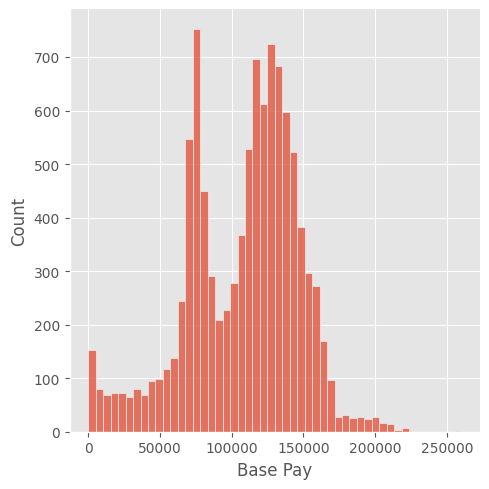

In [16]:
sns.displot(data['Base Pay'])

## create feature columns
- `Total Year`
- `Job Title`
- `Start Salary` 
- `2018 Salary`
- `Increase Rate` : (2018-start)/start
- `2019 Salary` 

In [17]:
def total_year(values):
    return max(values)-min(values)

df_totalyear = data.groupby(['Employee Name','Job Title'], as_index=False)['Year'].agg([total_year])
df_startsalary = data.groupby('Employee Name').apply(lambda x: x.sort_values('Year').iloc[0]['Base Pay']).rename('Start Salary')
df_salary2018 = data[data['Year']==2018].groupby('Employee Name')['Base Pay'].max()
df_salary2019 = data[data['Year']==2019].groupby('Employee Name')['Base Pay'].max()

len(df_totalyear), len(df_startsalary), len(df_salary2018), len(df_salary2019)

(1963, 1963, 1734, 1963)

In [18]:
def increase_rate(salary_2018, salary_start):
    try:
        return (salary_2018 - salary_start) / salary_start
    except:
        return None

df = pd.merge(df_totalyear, df_startsalary, how='inner', left_on='Employee Name', right_index=True)
df = pd.merge(df, df_salary2018, how='inner', left_on='Employee Name', right_index=True)
df = pd.merge(df, df_salary2019, how='inner', left_on='Employee Name', right_index=True)
df.columns = ['Total Year', 'Start Salary', '2018 Salary', '2019 Salary']
df.reset_index(inplace=True)
df['Increase Rate'] = df.apply(lambda row: increase_rate(row['2018 Salary'], row['Start Salary']), axis=1)
df = df[['Employee Name', 'Job Title', 'Total Year','Start Salary','2018 Salary', 'Increase Rate', '2019 Salary']]
df

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13
...,...,...,...,...,...,...,...
1729,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11
1730,ZENAIDA L RAMOS,NURSING ASSISTANT,5,67948.00,10496.34,-0.845524,0.00
1731,ZERINA O BANGAWAN,REGISTERED NURSE,3,4127.90,138956.52,32.662763,142609.16
1732,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51


## fitler only those who work at least 2 years

In [19]:
df = df[df['Total Year'] > 0].reset_index(drop=True)
df

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13
...,...,...,...,...,...,...,...
1729,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11
1730,ZENAIDA L RAMOS,NURSING ASSISTANT,5,67948.00,10496.34,-0.845524,0.00
1731,ZERINA O BANGAWAN,REGISTERED NURSE,3,4127.90,138956.52,32.662763,142609.16
1732,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51


# EDA

### distribution of `2019 Salary` by `Job Title`

### distribution of `Start Salary` and `2019 Salary`

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
sns.histplot(ax=axes[0], x=df['Start Salary'])
sns.histplot(ax=axes[1], x=df['2019 Salary']);

- **there are 2 peaks**
- Salary should not be less than 10000$, it's below minimum wage of full-time worker
- Such data is not a outlier, but incorrect data -> we can drop from both train and test  
- some people do not work whole year, that may cause this incorrectness

In [21]:
## drop salary < 10000

df = df[(df['2019 Salary'] > 10000) & (df['Start Salary'] > 10000)].reset_index(drop=True)
df

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13
...,...,...,...,...,...,...,...
1607,YVONNE FUENTESPATTISHALL,REGISTERED NURSE,7,119409.99,155264.01,0.300260,164250.50
1608,ZAR N MAW,REGISTERED NURSE,1,64910.38,64910.38,0.000000,93285.77
1609,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11
1610,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51


In [22]:
job_count = df.groupby('Job Title')['Employee Name'].count().sort_values(ascending=False).to_frame().reset_index()

fig, axes = plt.subplots(1,2, figsize=(12, 6))
sns.boxplot(ax=axes[0], x='2019 Salary', y='Job Title', data=df, order=job_count['Job Title'])
sns.barplot(x='Employee Name', y='Job Title', data=job_count).set(\
            yticklabels=job_count['Employee Name'], xlabel='count', ylabel=None);

### pairplot

In [23]:
numeric_cols = ['Total Year', 'Start Salary','2018 Salary','Increase Rate', '2019 Salary']
sns.pairplot(df[numeric_cols])

### correlation

In [24]:
numeric_cols = ['Total Year', 'Start Salary','2018 Salary','Increase Rate', '2019 Salary']
sns.heatmap(df[numeric_cols].corr(), annot=True)

<AxesSubplot:>

### col_to_scale scatterplot `Start Salary` vs `2019 Salary` by `Job Title`

- hypothesis : for some job, it is likely to raise salary

In [25]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='2019 Salary', hue='Job Title', data=df)
plt.plot([10000,210000],[10000,210000])

### col_to_scale scatterplot `Start Salary` vs `2019 Salary` by `Total Year`

- hypothesis : The longer they work, the more wage rise - True or Not??

In [26]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='2019 Salary', hue='Total Year', data=df)
plt.plot([10000,210000],[10000,210000])

In [27]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='Increase Rate', hue='Total Year', data=df)

<AxesSubplot:xlabel='Start Salary', ylabel='Increase Rate'>

### summary of EDA

# Modelling 1
- start from only 2 features : `Start Salary` and `Job Title`
- baseline : `Dummy Regressor`
- correlation between `Start Salary` and `2019 Salary` is 0.49

## train-test split

In [28]:
X = df[['Start Salary', 'Job Title']]
y = df['2019 Salary']

In [29]:
## stratify = X['Job Title'] because some Job Title are few data
## make array of original Job Title because it will be dummied up  
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X, y, X['Job Title'], test_size=0.15, random_state=42, stratify=X['Job Title'])

## dummy up Job Title
X_train = pd.get_dummies(X_train, columns=['Job Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Job Title'], drop_first=True)

## check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1370, 5), (242, 5), (1370,), (242,))

In [30]:
## function for evaluation
def evaluate(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE : {mae:.4f}')
    print(f'R2  : {r2:.4f}')
    
    residual = y_pred - y_test
    plt.scatter(y_test, residual)
    plt.ylabel('residual'); plt.xlabel('y_true')
    plt.show()

## Dummy Regressor - baseline score

RMSE: 40331.3987
MAE : 32656.2909
R2  : -0.0146


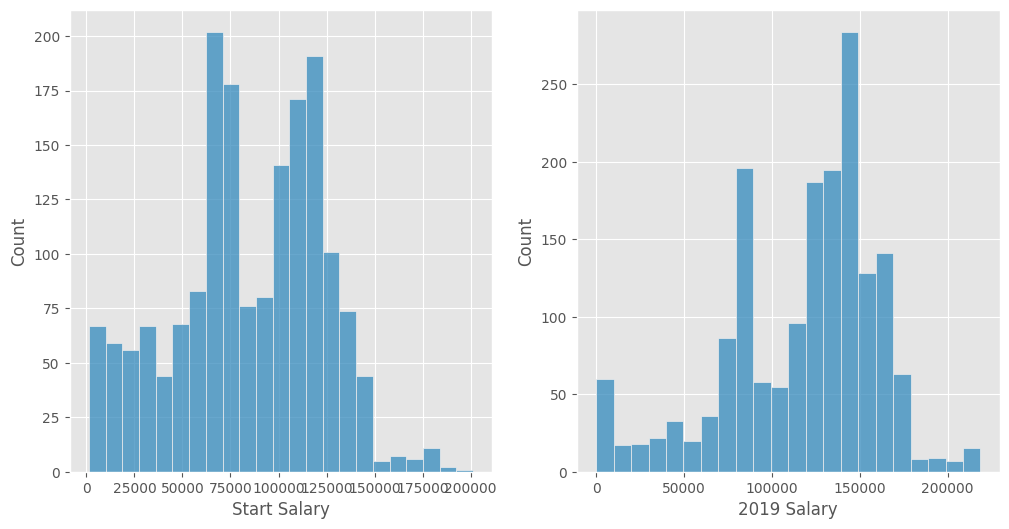

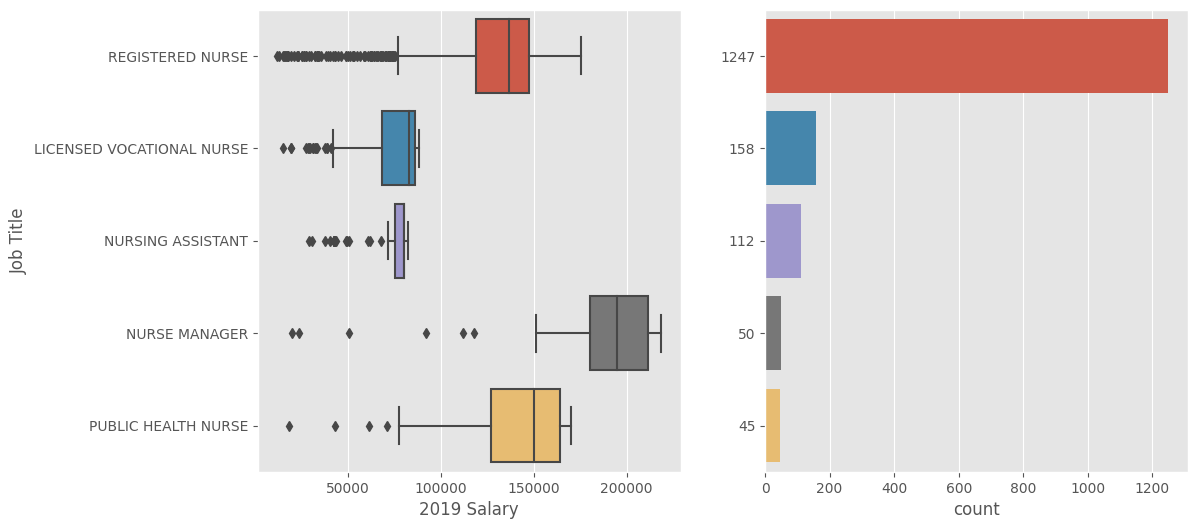

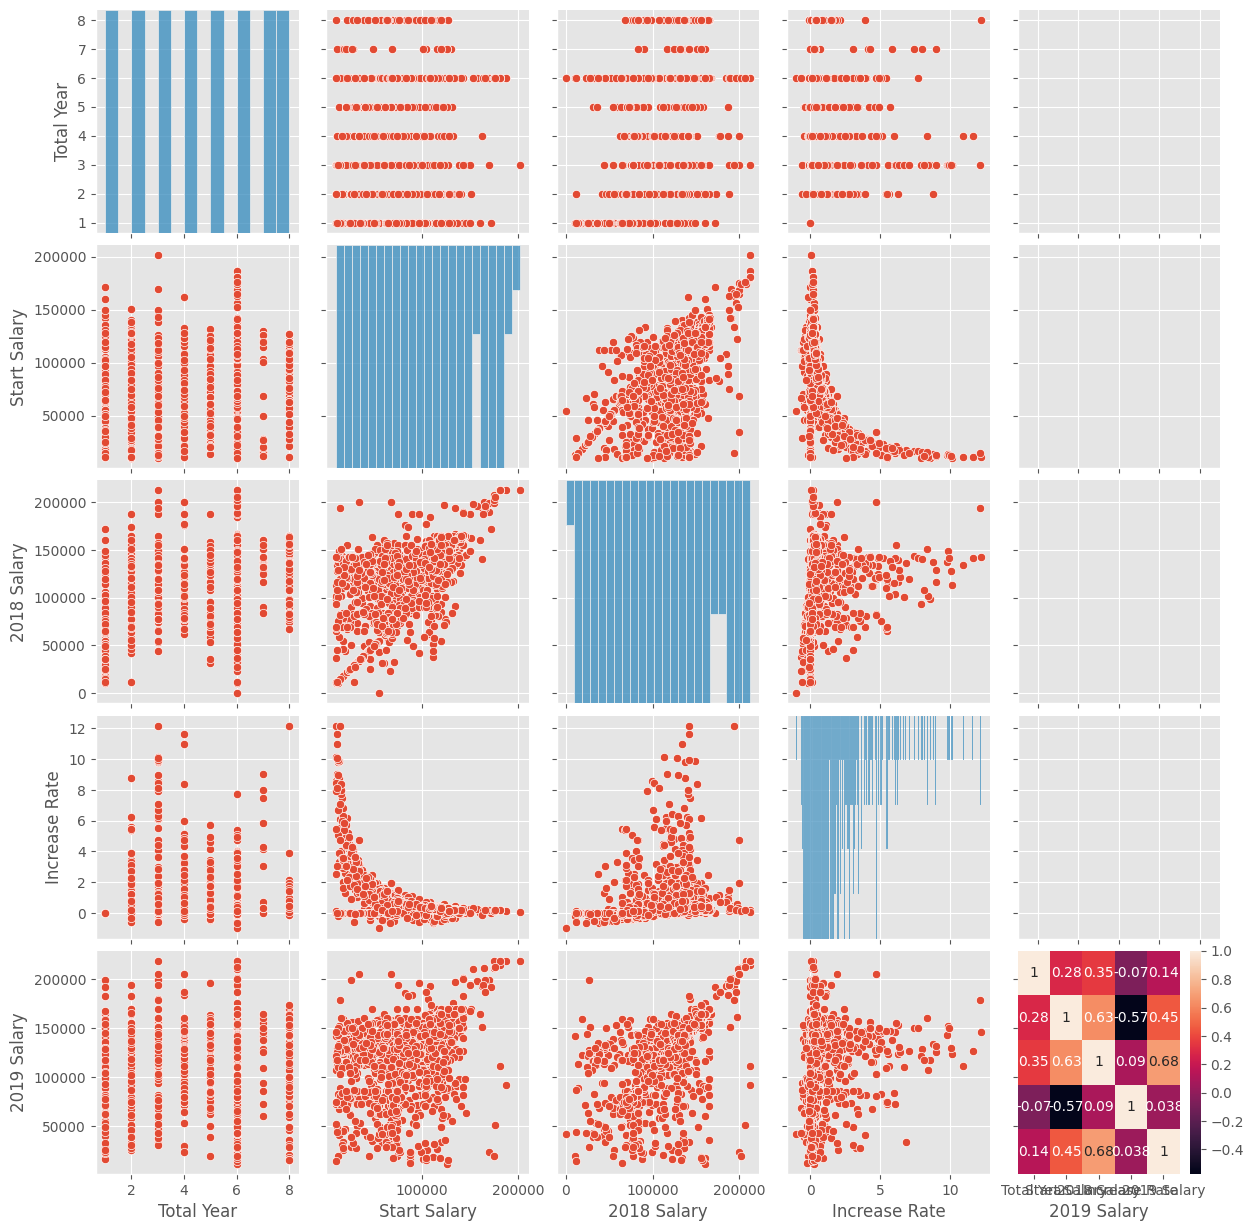

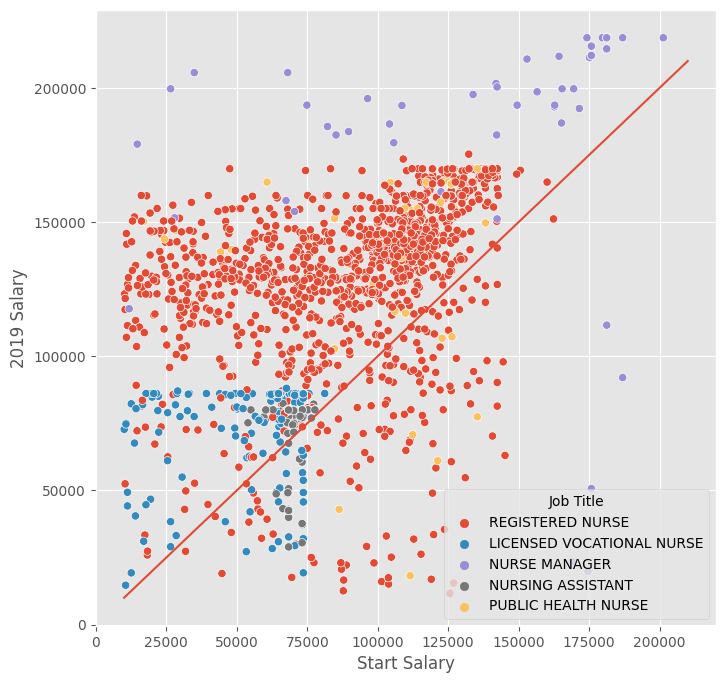

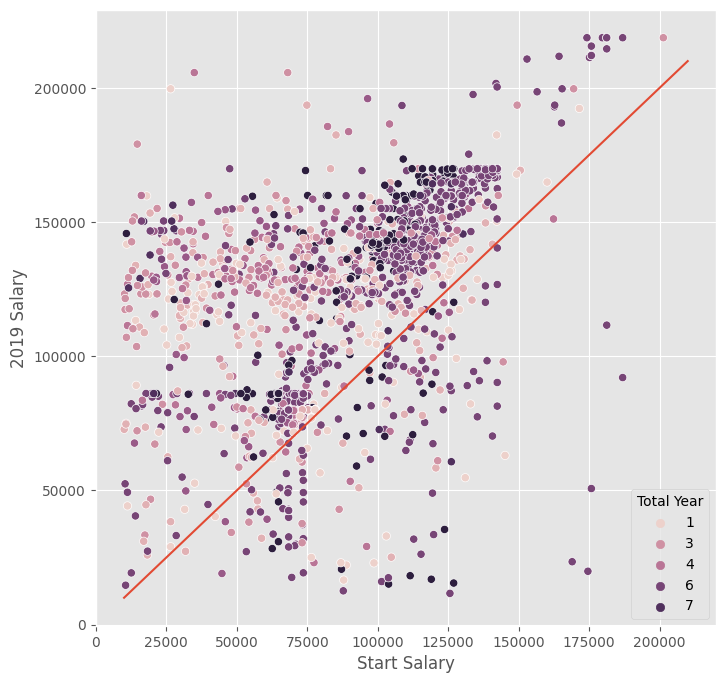

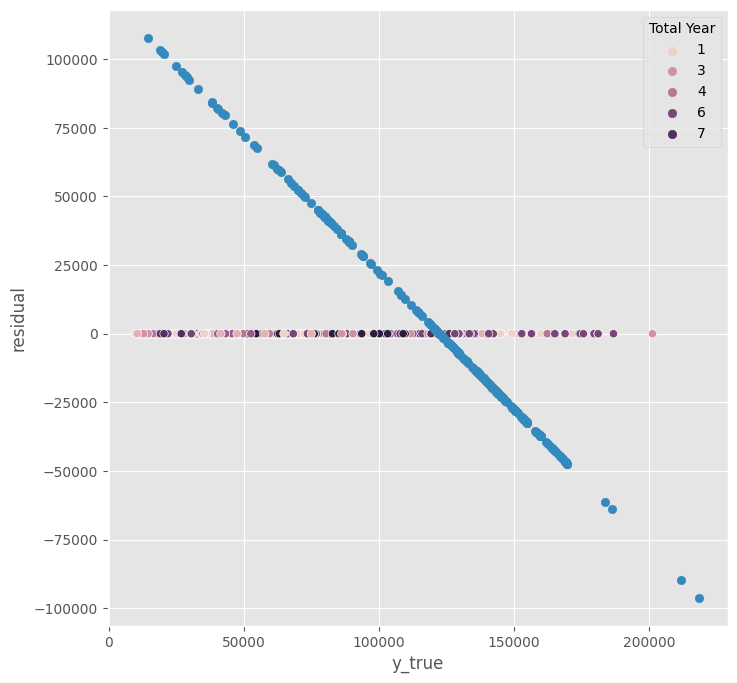

In [31]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

evaluate(dummy)

## Linear Regression

RMSE: 33417.6207
MAE : 22355.6303
R2  : 0.3034


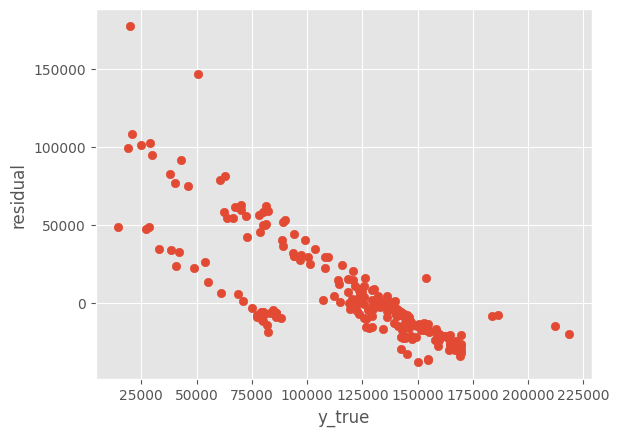

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

evaluate(lr)

- score is better than dummy regressor
- **there are 2 lines**
- for lower salary, predict > actual
- for higher salary, predict < actual

-> **check distribution of each job**

In [33]:
def plot_predict_by_job(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    temp_df = pd.DataFrame({'pred':y_pred,'true':y_test,'Job Title':job_test})
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
    plt.plot([20000,210000],[20000,210000])

In [34]:
plot_predict_by_job(lr)

- clusters are clear. predicted values are strongly correlated with `Job Title`
- i.e. for the same Job Title, the model predicts similar values

# Modelling 2
- try to use `Total Year`

In [35]:
X = df[['Start Salary', 'Total Year', 'Job Title']]
y = df['2019 Salary']

## stratify = X['Job Title'] because some Job Title are few data
## make array of original Job Title because it will be dummied up  
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X, y, X['Job Title'], test_size=0.15, random_state=42, stratify=X['Job Title'])

## dummy up Job Title
X_train = pd.get_dummies(X_train, columns=['Job Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Job Title'], drop_first=True)

## check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1370, 6), (242, 6), (1370,), (242,))

In [36]:
X_train.columns

Index(['Start Salary', 'Total Year', 'Job Title_NURSE MANAGER',
       'Job Title_NURSING ASSISTANT', 'Job Title_PUBLIC HEALTH NURSE',
       'Job Title_REGISTERED NURSE'],
      dtype='object')

RMSE: 33353.3950
MAE : 22121.4657
R2  : 0.3061


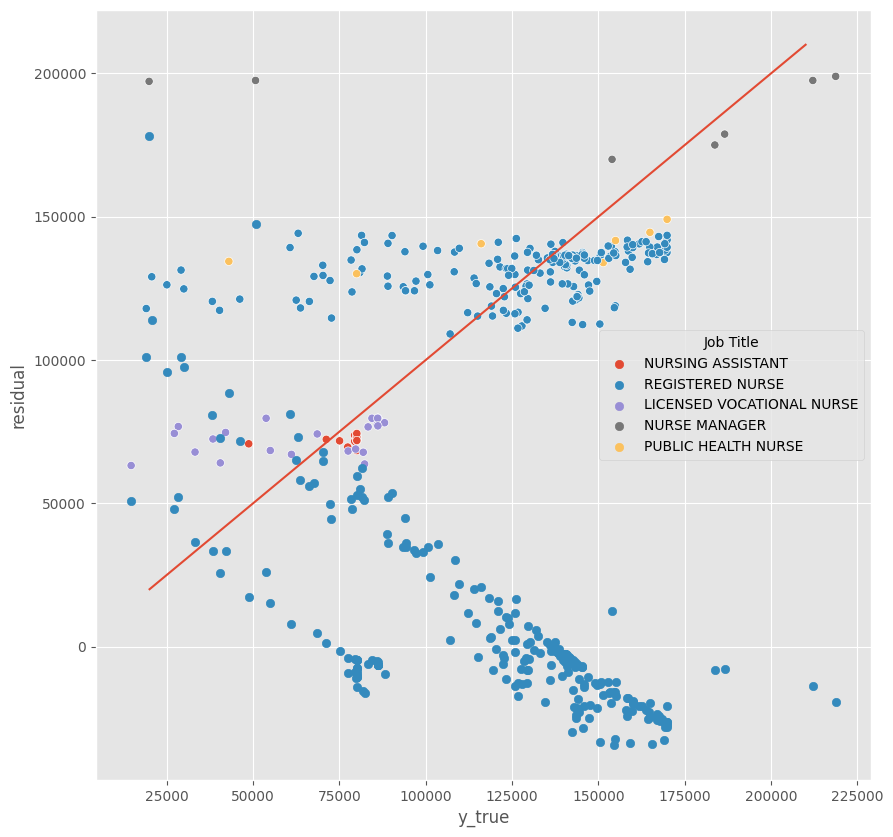

In [37]:
## Linear Regression with scaling
col_to_scale = ['Start Salary']

sc = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[col_to_scale] = sc.fit_transform(X_train[col_to_scale])

X_test_sc = X_test.copy()
X_test_sc[col_to_scale] = sc.transform(X_test[col_to_scale])

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

evaluate(lr, X_test=X_test_sc)

In [38]:
## coefficients
pd.DataFrame({'coef':lr.coef_}, index=lr.feature_names_in_)

,coef
Start Salary,8147.571608
Total Year,1633.170989
Job Title_NURSE MANAGER,95469.326601
Job Title_NURSING ASSISTANT,-3224.715886
Job Title_PUBLIC HEALTH NURSE,53840.673272
Job Title_REGISTERED NURSE,48506.082989


In [39]:
plot_predict_by_job(lr, X_test=X_test_sc)

- Is this model better than previous model?

In [40]:
def plot_predict_by_totalyear(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    temp_df = pd.DataFrame({'pred':y_pred,'true':y_test,'Total Year':X_test['Total Year']})
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='true',y='pred',hue='Total Year',data=temp_df)
    plt.plot([20000,210000],[20000,210000])
    
plot_predict_by_totalyear(lr, X_test_sc)

- Does `Total Year` form cluster?

# Modelling 3
- try to use `Make 2 model from jobs`

In [41]:
df.columns

Index(['Employee Name', 'Job Title', 'Total Year', 'Start Salary',
       '2018 Salary', 'Increase Rate', '2019 Salary'],
      dtype='object')

In [42]:
X = df[['Start Salary', 'Total Year', 'Job Title']]
y = df['2019 Salary']

## stratify = X['Job Title'] because some Job Title are few data
## make array of original Job Title because it will be dummied up  
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X, y, X['Job Title'], test_size=0.15, random_state=42, stratify=X['Job Title'])

## dummy up Job Title
X_train = pd.get_dummies(X_train, columns=['Job Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Job Title'], drop_first=True)
X_train = df.drop(['NURSE MANAGER','NURSING ASSISTANT','LICENSED VOCATIONAL NURSE'],axis=1)

## check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

KeyError: "['NURSE MANAGER', 'NURSING ASSISTANT', 'LICENSED VOCATIONAL NURSE'] not found in axis"

In [ ]:
X_train

In [ ]:
## Linear Regression with scaling
col_to_scale = ['Start Salary']

sc = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[col_to_scale] = sc.fit_transform(X_train[col_to_scale])

X_test_sc = X_test.copy()
X_test_sc[col_to_scale] = sc.transform(X_test[col_to_scale])

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

evaluate(lr, X_test=X_test_sc)